In [1]:
########################
#
# Excersises
#
########################


### E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?


In [1]:
import torch
import matplotlib.pyplot as plt 
import torch.nn.functional as F

import requests 

In [2]:
# url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
url = "https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt" #English dictionary

res = requests.get(url)
words = (res.text).splitlines()
print(len(words), max(len(w) for w in words), min(len(w) for w in words))

370105 31 1


In [3]:
chars = sorted(list(set((''.join(words)))))  #get unique characters 
stoi = {s:i+1 for i, s in enumerate(chars)}  # map char to int
stoi["."] = 0 
itos = {i:s for s,i in stoi.items()}         # map int to char

In [4]:
# calculate trigram frequencies in Matrix Form 
N = torch.zeros( 27, 27, 27, dtype=int)
b = {}
for w in  words:
    chs =  ['.']  + ['.']  +  list(w) + ['.'] 
    
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1][ix2][ix3] += 1
    

In [5]:
# Convert trigram frequency matrix to probability matrix
P=(N+ 0.0001).float()# adding 1 to prevent probability from being 0 giving infinite loss
P=P/P.sum(1, keepdim=True)
print(P.shape)

torch.Size([27, 27, 27])


In [15]:
# sampling dumb lang  model basesd on probability matrix 
g=torch.Generator().manual_seed(8979)
for i in range(20):

  ix1 = 0
  ix2 = 0 
  out = []
  while True:
    p = P[ix1][ix2] 
    
    # print(ix1,ix2)
    ix1=ix2
    ix2 = torch.multinomial(p,num_samples=1,replacement=True, generator=g).item()
    
    out.append(itos[ix2])
    
    if ix2 == 0:
      break
  print(''.join(out))

turvauxiddisjurbbablemodrommellenchippyx.
anquygmaywatiquerwomaspoxy.
verhyclouzzly.
dimeggezzly.
pabbimivexpospronwownighbury.
lifijo.
squbthbudiumalobrasictuatfujujy.
whequumuckbigrxyquus.
sly.
canzygrushikilvehylvexuaquayofshryhobwiverexpjexququarmizzlyhayscischliabrackqqkwquetedbakmquyizzaqurogypemulflubraffoxy.
ing.
sp.
thqubmil.
zifthygurumulshm.
reabshuvigrahiaxysympajawshiquoywephowbupreallygo.
j.
wage.
forwebumopawbed.
nuffelswrekkeywoospuffakfuffescial.
pastwuquumbruvapatzkjqxzjji.


In [7]:
# loss calculation for model based on probability materix 
logLikelihood = 0.0
nll = 0
n = 0
for w in  words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1][ix2][ix3]
        logprob = torch.log(prob) #multiplication of probabilites same as addition of negative log probabilites
        logLikelihood += logprob
        n += 1  
    nll = -logLikelihood
      
print(f"log {logLikelihood}")
print(f"nll {nll}")
print(f"LOSS nll/n {nll/n}")

log -7122799.0
nll 7122799.0
LOSS nll/n 1.8429871797561646


In [8]:
#This model has lower loss compaerd to the bigram probability matrix model

In [9]:
#Now neural net work approach

In [10]:
#create training set 
xs, ys = [], []
n = 0
for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        # print(ch1,ch2) be carful with prints and for loops long for loops are very hard to stop ,kernel become un alive 
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [11]:
W = torch.randn((54,27),requires_grad=True).float()

0 tensor(4.3468, grad_fn=<AddBackward0>)
1 tensor(3.7407, grad_fn=<AddBackward0>)
2 tensor(3.4290, grad_fn=<AddBackward0>)
3 tensor(3.2268, grad_fn=<AddBackward0>)
4 tensor(3.0854, grad_fn=<AddBackward0>)
5 tensor(2.9826, grad_fn=<AddBackward0>)
6 tensor(2.9060, grad_fn=<AddBackward0>)
7 tensor(2.8477, grad_fn=<AddBackward0>)
8 tensor(2.8025, grad_fn=<AddBackward0>)
9 tensor(2.7664, grad_fn=<AddBackward0>)
10 tensor(2.7369, grad_fn=<AddBackward0>)
11 tensor(2.7122, grad_fn=<AddBackward0>)
12 tensor(2.6913, grad_fn=<AddBackward0>)
13 tensor(2.6733, grad_fn=<AddBackward0>)
14 tensor(2.6577, grad_fn=<AddBackward0>)
15 tensor(2.6441, grad_fn=<AddBackward0>)
16 tensor(2.6320, grad_fn=<AddBackward0>)
17 tensor(2.6213, grad_fn=<AddBackward0>)
18 tensor(2.6117, grad_fn=<AddBackward0>)
19 tensor(2.6031, grad_fn=<AddBackward0>)
20 tensor(2.5953, grad_fn=<AddBackward0>)
21 tensor(2.5882, grad_fn=<AddBackward0>)
22 tensor(2.5817, grad_fn=<AddBackward0>)
23 tensor(2.5758, grad_fn=<AddBackward0>)
24

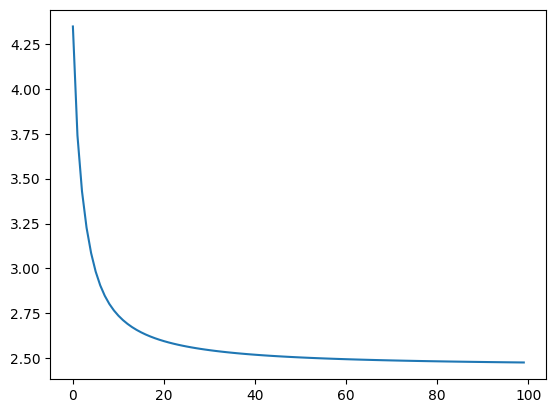

In [12]:
lossi= []

xenc=F.one_hot(xs,num_classes=27).float()
for k in range(100):
    # forward pass
    num=xs.shape[0]
    logits= xenc.view(-1,54)@W
    counts = logits.exp()
     
    probs = counts/counts.sum(1,keepdims=True)
    # loss calculation
    loss = -probs[torch.arange(num),ys].log().mean() +0.01*(W**2).mean() #regularization ie smoothing the weights
    
    # loss=F.cross_entropy(probs,ys) 
    W.grad=None 
    loss.backward()
    print(k,loss)
    lossi.append(loss.data)
    # update
    W.data += -50 * W.grad
plt.plot(lossi)

In [140]:
#achieved lower loss than model that took in single previous charecter in 100 steps